In [4]:
import sys
from pathlib import Path
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

PROJECT_ROOT = Path().resolve().parents[1]
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

from mnist_classifier.data import MNISTDataModule
from nn_utils import get_hidden_states, load_models
from nn_plotting import plot_perturved_accuracy
from local_corex import LinearCorex, partition_data
from local_corex._transformers import CorExWrapper, PCAWrapper
from local_corex.utils.plotting import (
    hidden_state_plot,
    multi_rep_plot,
)

# Download MNIST dataset if not already downloaded
from torchvision.datasets import MNIST
from torchvision import transforms
MNIST(f"{PROJECT_ROOT}", train=False, download=True, transform=transforms.ToTensor())

Dataset MNIST
    Number of datapoints: 10000
    Root location: C:\Users\tkerby2\Desktop\Projects
    Split: Test
    StandardTransform
Transform: ToTensor()

In [5]:
base_path = f"{PROJECT_ROOT}/Local_CorEx_Demo/paper_mnist/mnist_classifier/model"

sys.path.append(f"{PROJECT_ROOT}/Local_CorEx_Demo/paper_mnist/mnist_classifier/model")

from autoencoder_config import conf as ae_conf
from config import conf as clf_conf

ae_conf = ae_conf['autoencoder']
ae_ckpt = base_path + '/mnist_ae_epoch=091-val_loss=0.5937.ckpt'
clf_conf = clf_conf['classifier']
clf_ckpt = base_path + '/mnist_clf_epoch=068-val_loss=0.0006.ckpt'

do_ae, do_clf = load_models(ae_ckpt, clf_ckpt, ae_conf, clf_conf)

data_module = MNISTDataModule(clf_conf, f"{PROJECT_ROOT}")
data_module.setup('predict')

model_data = get_hidden_states(do_clf, data_module, device=do_clf.device, num_layers=len(clf_conf['hidden_layers']))

inputs=model_data[4]
labels=model_data[5]

do_state_df = pd.DataFrame({
    'input': list(inputs),
    'h1': list(model_data[1]),
    'h2': list(model_data[2]),
    'h3': list(model_data[3]),
    'output': list(model_data[0])
})

Inferred autoencoder config: {'encoder_layers': [500, 400, 300], 'decoder_layers': [400, 500], 'use_batch_norm': True, 'drop_out_p': 0.5, 'lr': 0.002}


computing clusters from scratch
Calculating PHATE...
  Running PHATE on 10000 observations and 784 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.38 seconds.
    Calculating KNN search...
    Calculated KNN search in 1.82 seconds.
    Calculating affinities...
    Calculated affinities in 0.12 seconds.
  Calculated graph and diffusion operator in 2.33 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 0.71 seconds.
    Calculating KMeans...
    Calculated KMeans in 1.98 seconds.
  Calculated landmark operator in 2.69 seconds.
  Calculating optimal t...
    Automatically selected t = 25
  Calculated optimal t in 2.21 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.52 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 6.09 seconds.
Calculated PHATE in 14.24 seconds.
saving clusters
Group number: 0 Counter({1: 392, 7: 8, 4: 8, 9: 6, 6: 1})
Group n

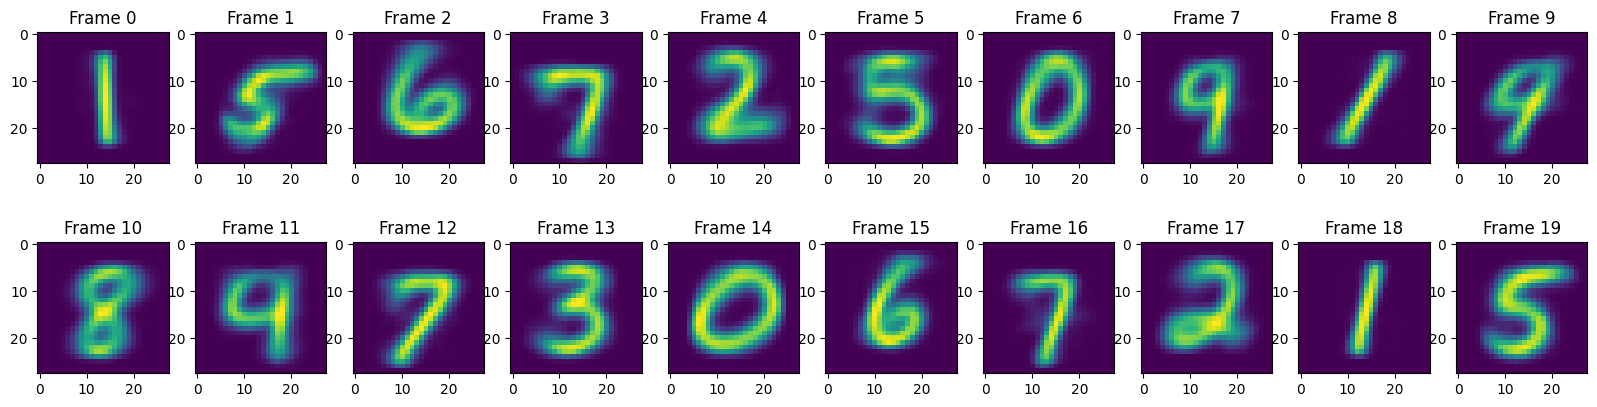

In [6]:
import pickle
from_scratch = True

if from_scratch:
    print('computing clusters from scratch')
    num_clusters=20
    indexes = partition_data(inputs, n_partitions=num_clusters, phate_dim=10, n_jobs=-2, seed=42)
    print('saving clusters')
    with open('mnist_20_indexes.pkl', 'wb') as f:
        pickle.dump(indexes, f)
else:
    print("loading clusters")
    with open('mnist_20_indexes.pkl', 'rb') as f:
        indexes = pickle.load(f)

for i in range(0, num_clusters):
    print("Group number:", i, Counter(labels[indexes[i]]))

fig, axes = plt.subplots(2, 10, figsize=(20, 5))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(np.mean(inputs[indexes[i]], axis = 0).reshape(28,28))
    ax.set_title('Frame ' + str(i))

[45.72718   21.866459  20.357748  14.032749  10.193449  10.01844
  7.1605716  6.9741306  6.7435174  6.360157   6.2827196  5.9463897
  5.525676   5.3336844  4.9015026  4.732793   4.351734   4.2894044
  4.189612   4.0386558  3.1639633  2.6469755  2.0909462  2.0421
  1.895348   1.6725427  1.5566133  1.5545154  1.2527337  0.9455931]


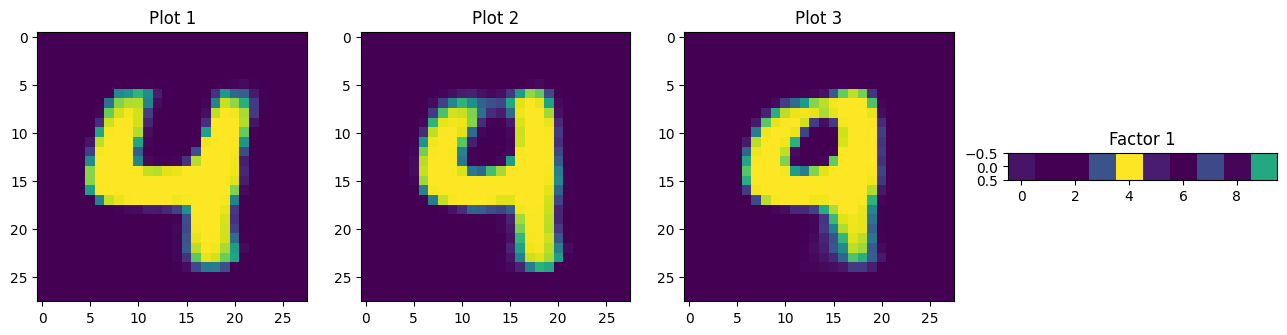

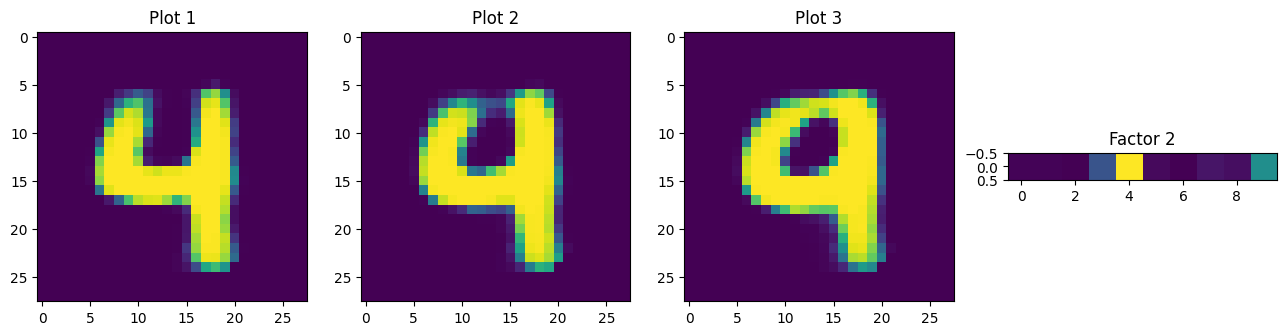

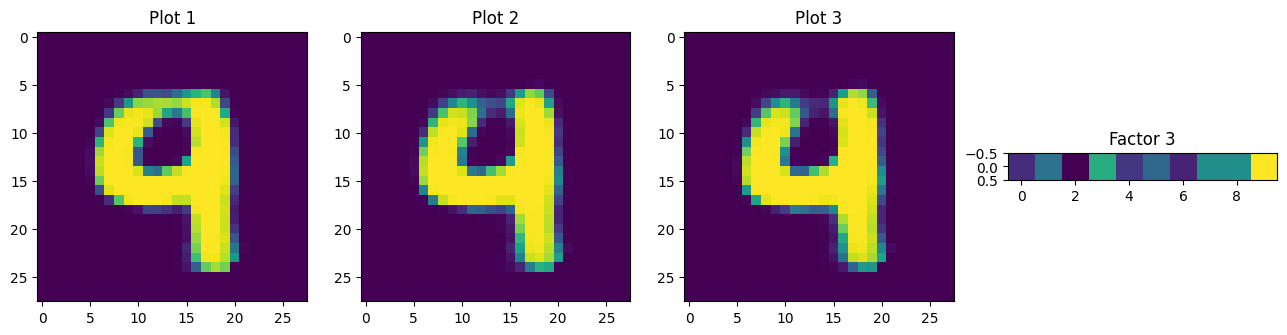

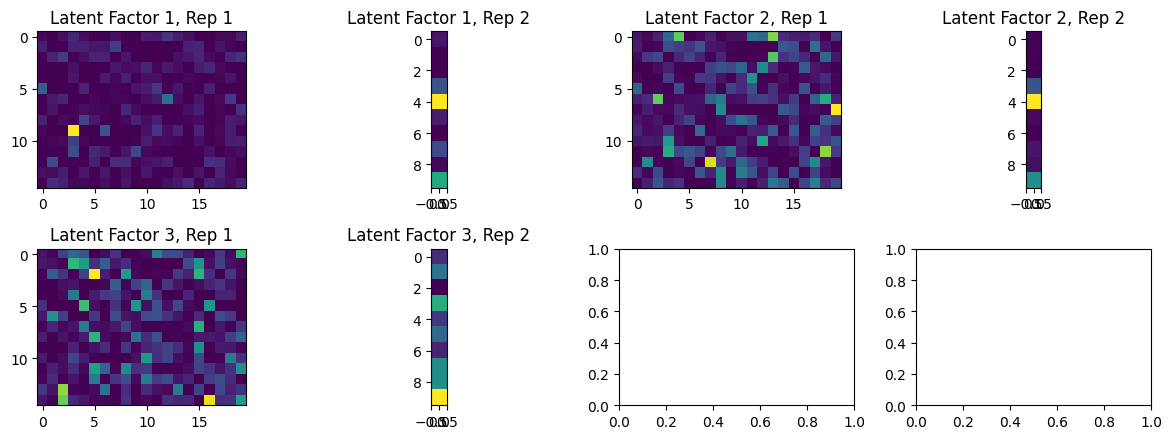

In [7]:
from local_corex import LinearCorex

partition=11
x = np.concatenate([model_data[3][indexes[partition]], model_data[0][indexes[partition]]], axis=1)

corex_h3_11 = LinearCorex(30, seed=42, gaussianize='outliers')
corex_h3_11.fit(x)
print(corex_h3_11.tcs)
hidden_state_plot(x, corex_h3_11, do_ae, factors=list(range(3)), latent_dim=300, encoder_layer=3, scaler=1.5, output_dim=10)
multi_rep_plot(corex_h3_11, 3, dims=[(15,20),(10,1)], num_per_row=2)

[23.974506  10.921288  10.303659   8.939697   8.53928    8.269547
  8.059006   7.591565   7.24749    6.1705317  5.90718    5.903507
  5.668092   5.211897   5.1850324  4.6938024  3.5650706  3.2764306
  3.2481387  3.0877073  2.9726017  2.831933   2.828853   2.4083111
  2.1983504  2.1396914  2.0188017  1.9796591  1.6734587  1.4697932]


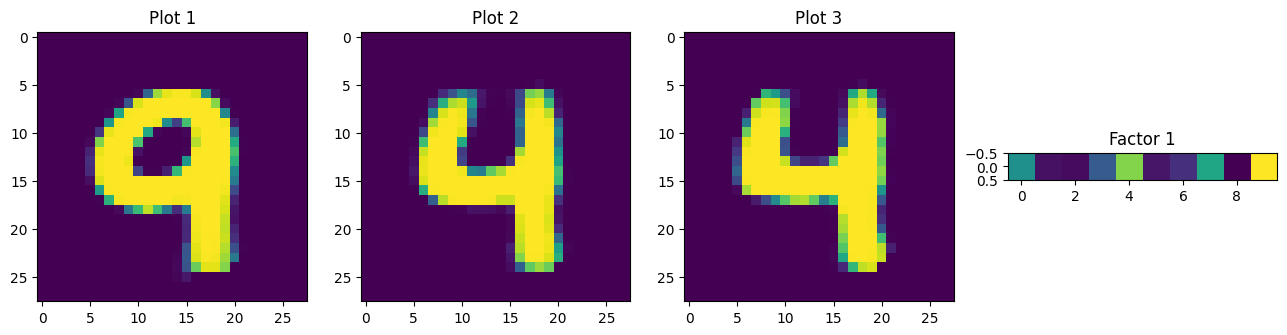

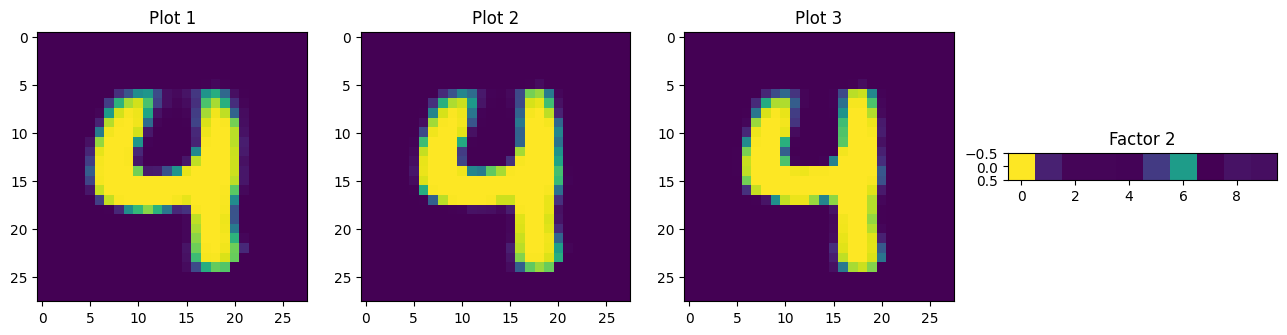

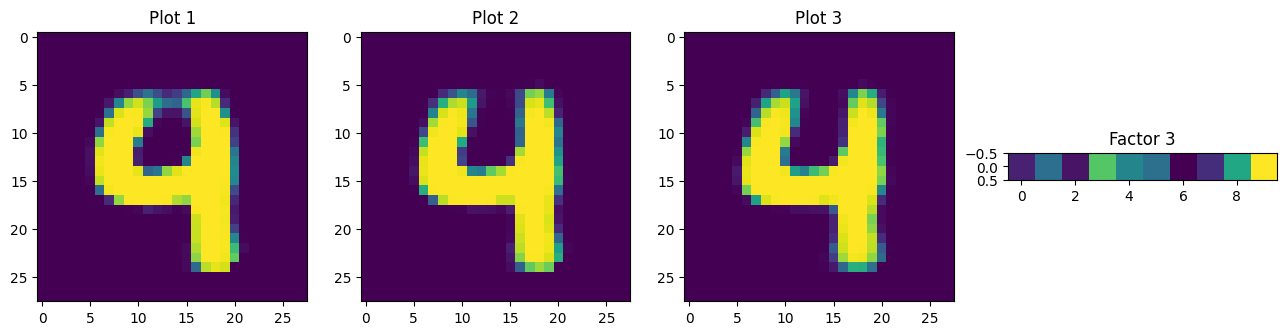

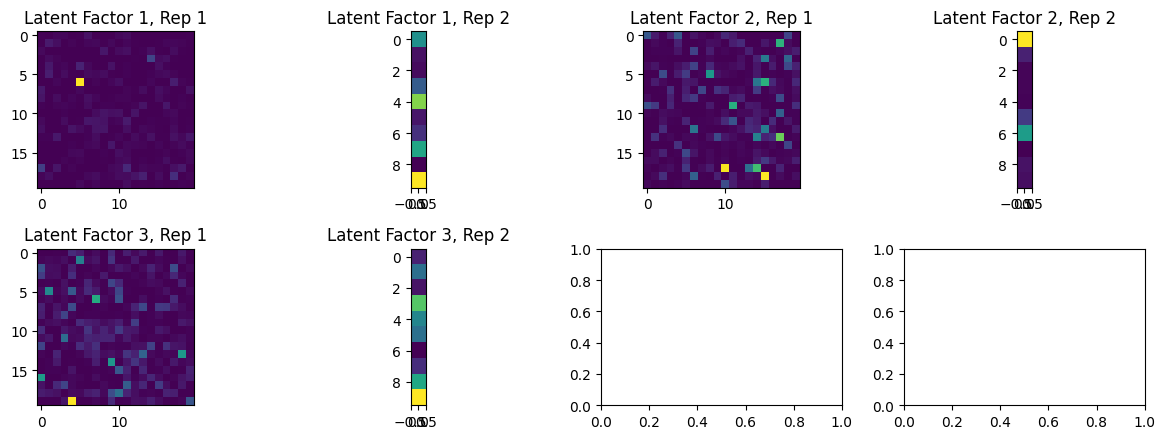

In [8]:
from local_corex import LinearCorex

partition=11
x = np.concatenate([model_data[2][indexes[partition]], model_data[0][indexes[partition]]], axis=1)

corex_h2_11 = LinearCorex(30, seed=42, gaussianize='outliers')
corex_h2_11.fit(x)
print(corex_h2_11.tcs)
hidden_state_plot(x, corex_h2_11, do_ae, factors=list(range(3)), latent_dim=400, encoder_layer=2, scaler=1.5, output_dim=10)
multi_rep_plot(corex_h2_11, 3, dims=[(20,20),(10,1)], num_per_row=2)

[16.169092  10.045535   9.994302   9.865547   9.623142   7.579365
  6.909263   6.3058925  6.301233   5.914345   5.9048734  5.8543425
  5.5419626  5.2777658  5.1169496  4.9667883  4.8873587  4.0785604
  3.9444356  3.872796   3.752746   3.631141   3.169236   3.0689008
  3.0051732  2.9450657  2.673708   2.0111368  1.8512197  1.7515371]


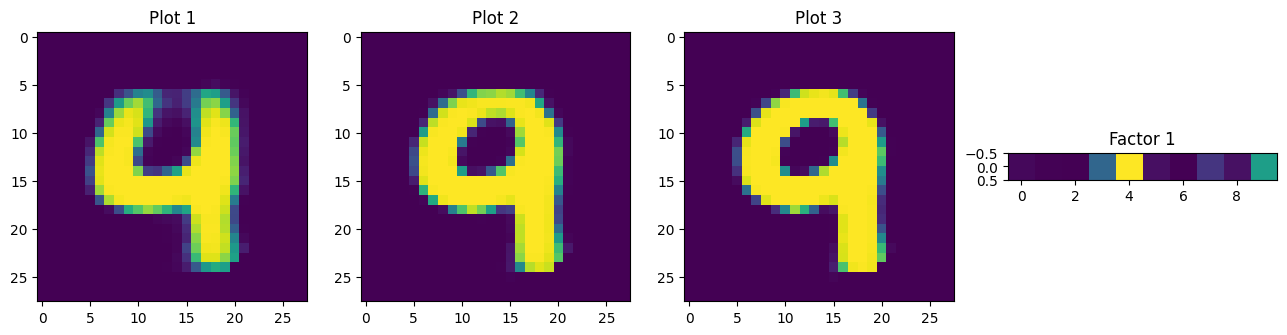

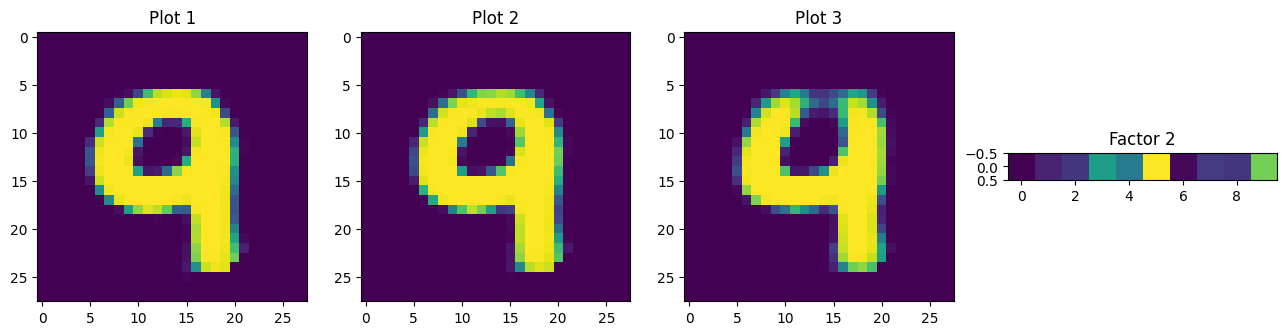

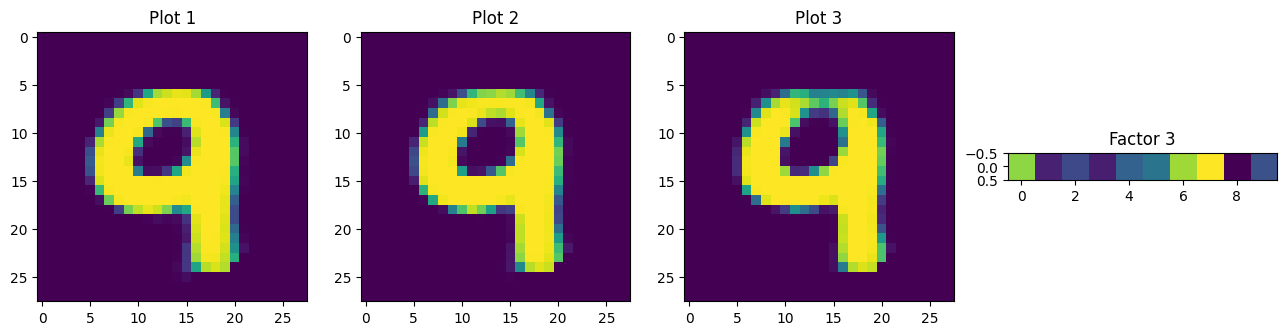

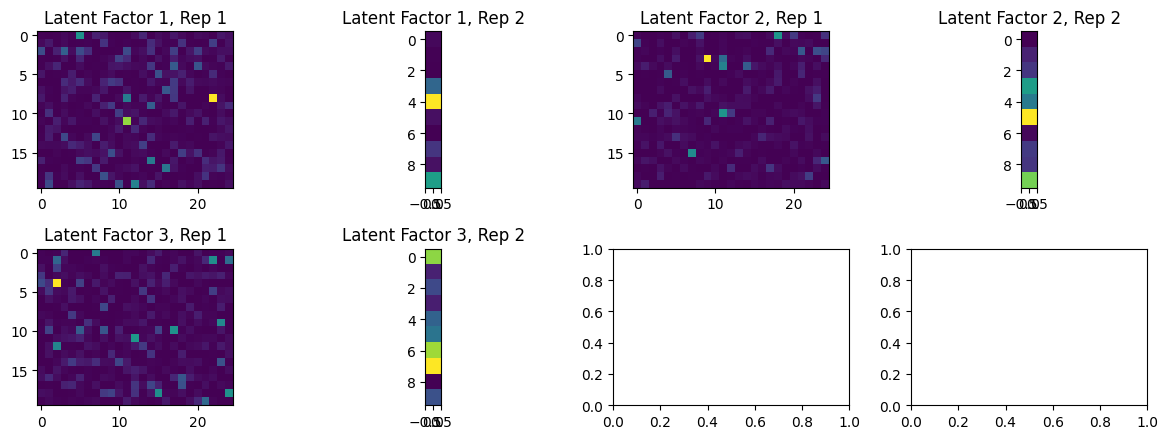

In [9]:
from local_corex import LinearCorex

partition=11
x = np.concatenate([model_data[1][indexes[partition]], model_data[0][indexes[partition]]], axis=1)

corex_h1_11 = LinearCorex(30, seed=42, gaussianize='outliers')
corex_h1_11.fit(x)
print(corex_h1_11.tcs)
hidden_state_plot(x, corex_h1_11, do_ae, factors=list(range(3)), latent_dim=500, encoder_layer=1, scaler=1.5, output_dim=10)
multi_rep_plot(corex_h1_11, 3, dims=[(20,25),(10,1)], num_per_row=2)

In [10]:
do_clf.to('cpu')
pred_digit = do_clf(torch.tensor(inputs)).max(1).indices.detach().numpy()
base_accuracies = []
for i in range(num_clusters):
    base_accuracies.append(100*np.mean(pred_digit[indexes[i]] == labels[indexes[i]]))
    print(i, np.round(np.mean(pred_digit[indexes[i]] == labels[indexes[i]]) * 100, 2))

0 98.55
1 98.86
2 99.08
3 97.81
4 98.73
5 96.28
6 98.76
7 97.74
8 96.76
9 98.57
10 98.83
11 99.43
12 98.16
13 99.63
14 99.8
15 98.81
16 97.46
17 99.54
18 99.49
19 99.12


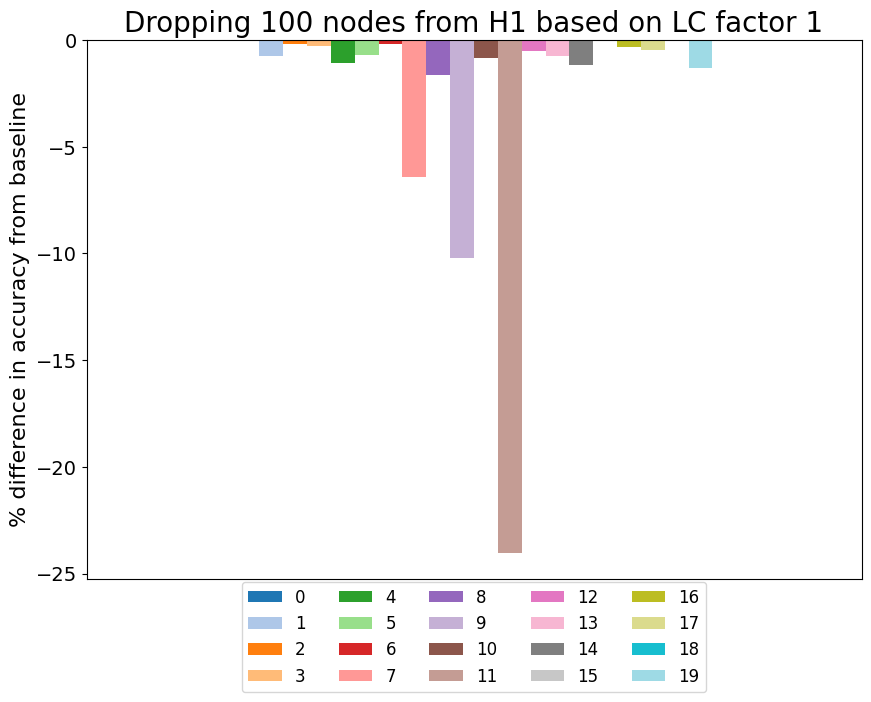

In [11]:
plot_perturved_accuracy(do_clf, corex_h1_11, inputs, labels, indexes, 
                             factor_num=0, hidden_layer_idx=0, num_clusters=20, 
                             num_drop=100, hidden_dim=500)

210.0


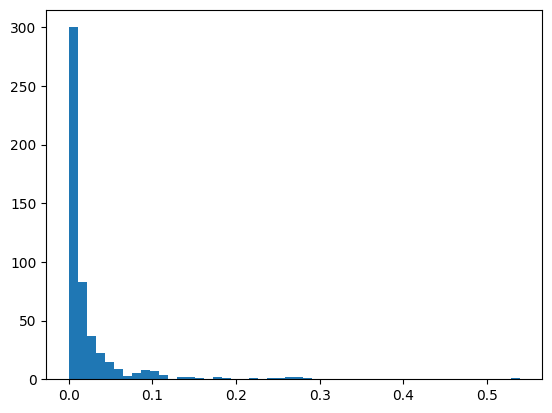

In [12]:
output = plt.hist(corex_h1_11.moments['MI'][2], bins=50)
print(np.sum(output[0][1:]))

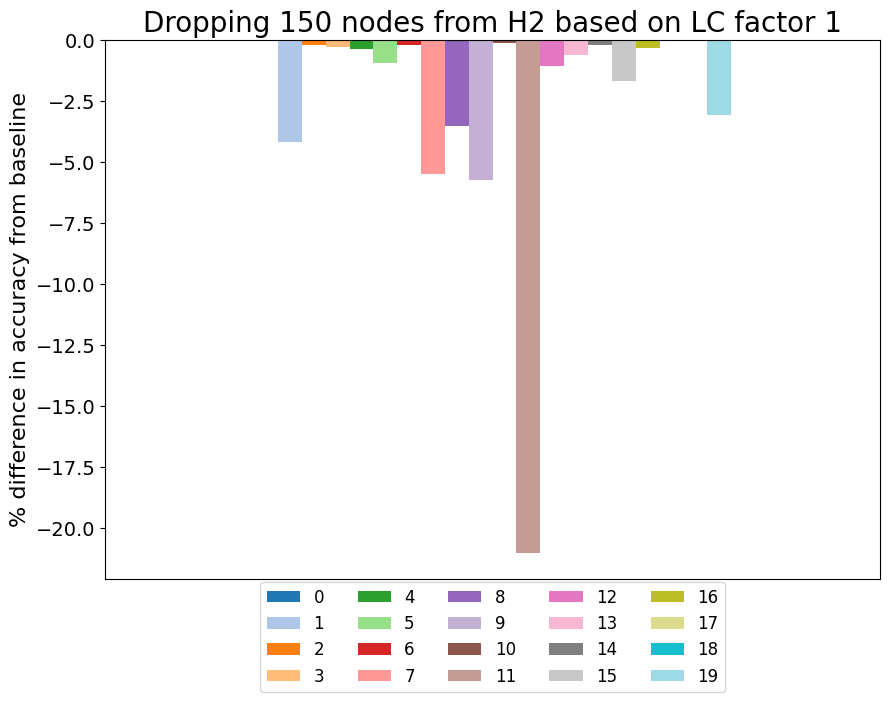

In [13]:
plot_perturved_accuracy(do_clf, corex_h2_11, inputs, labels, indexes, 
                             factor_num=0, hidden_layer_idx=1, num_clusters=20, 
                             num_drop=150, hidden_dim=400)

104.0


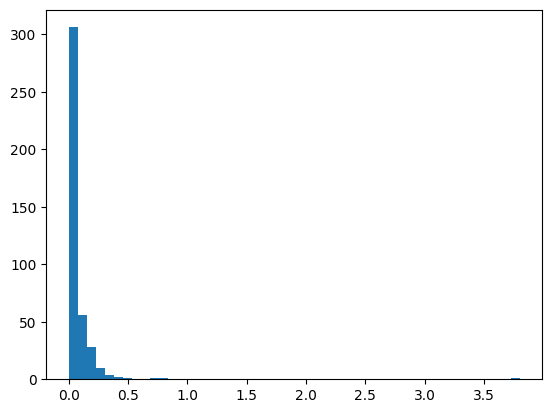

In [14]:
output = plt.hist(corex_h2_11.moments['MI'][0], bins=50)
print(np.sum(output[0][1:]))

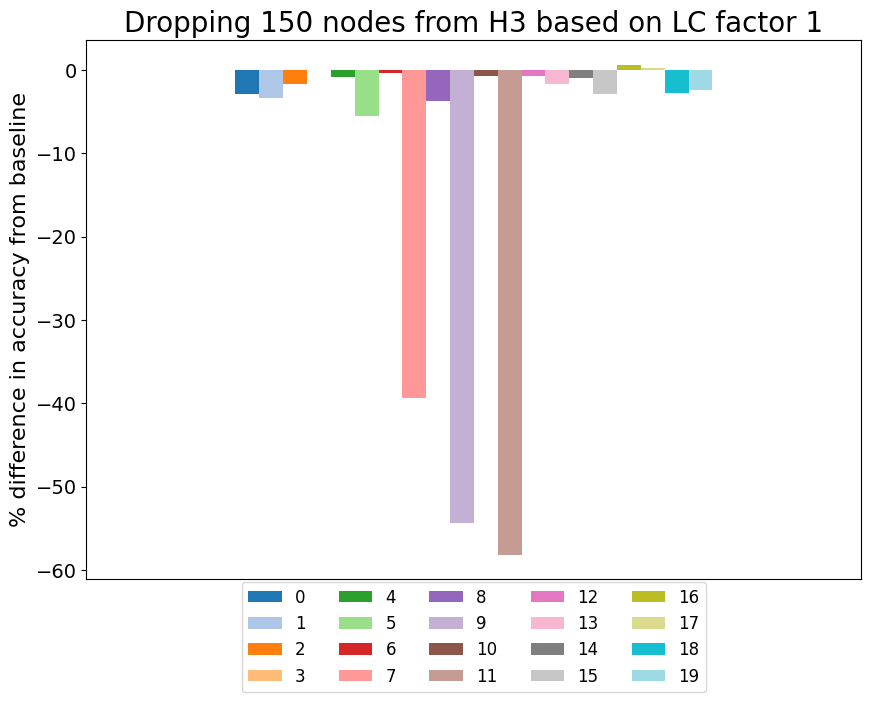

In [15]:
plot_perturved_accuracy(do_clf, corex_h3_11, inputs, labels, indexes, 
                             factor_num=0, hidden_layer_idx=2, num_clusters=20, 
                             num_drop=150, hidden_dim=300)

89.0


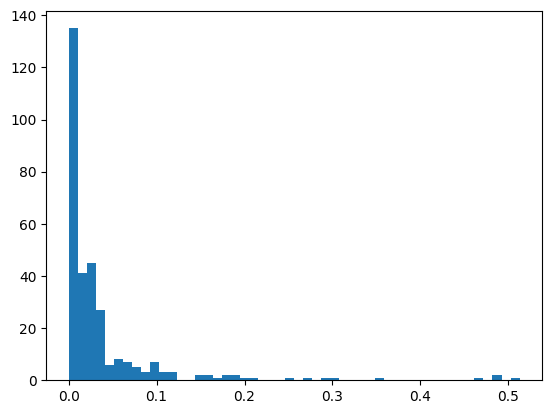

In [16]:
output = plt.hist(corex_h3_11.moments['MI'][5], bins=50)
print(np.sum(output[0][3:]))